In [1]:
#MLP problems :

#1. for image classification problems, each node in each hidden layer need to estimate weights of pixel hight *pixel width. for 100**100 image we need to calc 10000 weights in each layer which is not scalable.
#2. it's not clear that whether this MLP will still perform well if the image is shifted by one pixelis
#3. even complicated images like this browny teddy bear in a background tend to have correlated pixels. for example any brownish pixel in  image tends to be close to other brown pixels and any white pixel tends to be near other white pixels and MLP don't have the ability to  take advantage of the correlation that exists among each pixel.

In [1]:
#Why CNN 

#1. they reduce the number of input nodes (convolution,maxpooling)


#2. they tolerate small shifts in where the pixels are in the image


#3. take advantage of the correlations that we observe in complex images


In [2]:
import torch
import torchvision.transforms as transforms
import pandas as pd

import torch.nn as nn

import torchvision.datasets as datasets
import torch.nn.functional as F

import matplotlib.pylab as plt
import numpy as np

import cv2
import time
from math import floor

from torch.utils.data import Dataset
from torch.utils.data import DataLoader



In [2]:
# Load the .csv file into a Pandas DataFrame
df_training = pd.read_csv('/home/bibin/MAI/2nd_sem/ANN/dataset/train.csv')
df_training

,id,image,classification
0,0,2_000000.png,7
1,1,0_000001.png,2
2,2,1_000002.png,7
3,3,3_000003.png,4
4,4,1_000004.png,3
...,...,...,...
239995,239995,2_239995.png,4
239996,239996,1_239996.png,5
239997,239997,3_239997.png,7
239998,239998,3_239998.png,1


In [3]:
#image_list = []
image = df_training['image'].to_list()
labels = df_training['classification'].to_list()


In [4]:
zero = np.zeros((240000,28,28),dtype=np.uint8) 

In [5]:
for i in range(240000):
    zero[i] = cv2.imread(f'dataset/train/{labels[i]}/{image[i]}',0)

In [6]:
zero = zero/255 #normalizing data

In [7]:
images = torch.tensor(zero).reshape((240000,1,28,28)).float() #wait convert from numpy array into torch tensor with shape(240000,1,28,28)

In [8]:
classes = torch.tensor(labels)
classes = classes.type(torch.LongTensor)

In [9]:
classes

tensor([7, 2, 7,  ..., 7, 1, 8])

In [10]:
class ImageLabelDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return (image, label)


training_set = ImageLabelDataset(images, classes)

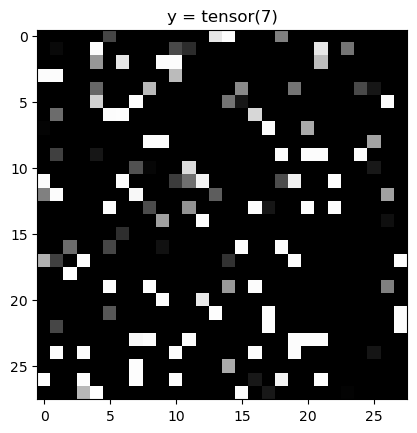

In [11]:
def shows_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))
shows_data(training_set[0])

In [17]:
train_loader = DataLoader(training_set, batch_size=32, shuffle=True)

In [18]:
def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):  
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor( ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w = floor( ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    return h, w
#This function calculates the output shape of a 2D convolutional layer. It takes in the input image's height and width (h_w) as a tuple, the kernel size, stride, padding and dilation as parameters. It first checks if the kernel size is a tuple or not, and converts it to a tuple if it is not. Then, it calculates the output height and width using the given formula and returns the output shape as a tuple of (height, width).

In [19]:
out=conv_output_shape((28,28), kernel_size=5, stride=1, pad=2, dilation=1)
print(out)
out1=conv_output_shape(out, kernel_size=2, stride=1, pad=0, dilation=1)
print(out1)
out2=conv_output_shape(out1, kernel_size=5, stride=1, pad=2, dilation=1)
print(out2)

out3=conv_output_shape(out2, kernel_size=2, stride=1, pad=0, dilation=1)
print(out3)

(28, 28)
(27, 27)
(27, 27)
(26, 26)


In [39]:
class CNN(nn.Module):
    # Contructor
    def __init__(self, out_1=16, out_2=32, out_3=64):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, stride=1, padding=2)
        self.batchnorm1 = nn.BatchNorm2d(out_1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(out_2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.cnn3 = nn.Conv2d(in_channels=out_2, out_channels=out_3, kernel_size=5, stride=1, padding=2)
        self.batchnorm3 = nn.BatchNorm2d(out_3)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(576, 256)
        self.dropout1 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(p=0.3)
        self.fc4 = nn.Linear(64,10)
        

    # Prediction

    def forward(self, x):
        x = self.cnn1(x)
        x = self.batchnorm1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = self.batchnorm2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = self.cnn3(x)
        x = self.batchnorm3(x)
        x = torch.relu(x)
        x = self.maxpool3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.dropout3(x)
        x = self.fc4(x)
    
        return x
    
#The constructor of the class initializes the different layers of the CNN:

#3 convolutional layers (cnn1, cnn2, cnn3) with kernel size 5, stride 1 and padding 2, the number of output channels out_1, out_2, out_3 respectively.
#3 batch normalization layers (batchnorm1, batchnorm2, batchnorm3) to normalize the output of each convolutional layer.
#3 maxpool layers (maxpool1, maxpool2, maxpool3) with kernel size 2 and stride 2 to reduce the spatial dimensions of the feature maps.
#4 fully connected layers (fc1, fc2, fc3, fc4) with decreasing number of neurons.
#3 dropout layers (dropout1, dropout2, dropout3) with probability of 0.3 to prevent overfitting.
#The forward method of the class defines the forward pass of the CNN. It applies the different layers to the input tensor x in the order they were defined in the constructor. The input is passed through the convolutional layers, batch normalization layers, and maxpool layers, then the output is passed through the fully connected layers and dropout layers, and finally the output of the last fully connected layer is returned. The activation function used is ReLU.       

In [40]:
# Create the criterion function
criterion = nn.CrossEntropyLoss()

In [62]:
# Set the parameters for create the model
# Create the model object using CNN class

model = CNN(out_1=16, out_2=32, out_3=64)
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [63]:
# Train the model

n_epochs = 100
loss_list = []
print_interval = 1

def train_model(n_epochs):
    for epoch in range(n_epochs):
        start_time = time.time()
        for x, y in train_loader:
            
            # Zero the gradients
            optimizer.zero_grad() 
            
            # Forward pass
            z = model(x)   
            loss = criterion(z, y)
            
            # Backward pass
            loss.backward()
            
            # Update the weights
            optimizer.step()                 
            loss_list.append(loss.data.item())
            
        elapsed_time = time.time() - start_time
        print('Elapsed time for epoch {}: {:.2f} seconds'.format(epoch+1, elapsed_time))
         # Print the loss at the specified interval
        if epoch % print_interval == 0:
            print(f'Epoch {epoch}: Loss = {loss.data.item():.4f}') 
    


In [64]:
train_model(n_epochs)

Elapsed time for epoch 1: 165.50 seconds
Epoch 0: Loss = 0.4942
Elapsed time for epoch 2: 194.71 seconds
Epoch 1: Loss = 0.2893
Elapsed time for epoch 3: 209.00 seconds
Epoch 2: Loss = 0.2120
Elapsed time for epoch 4: 225.68 seconds
Epoch 3: Loss = 0.2929
Elapsed time for epoch 5: 249.97 seconds
Epoch 4: Loss = 0.1540
Elapsed time for epoch 6: 251.21 seconds
Epoch 5: Loss = 0.1774
Elapsed time for epoch 7: 212.29 seconds
Epoch 6: Loss = 0.0868
Elapsed time for epoch 8: 185.29 seconds
Epoch 7: Loss = 0.1044
Elapsed time for epoch 9: 165.91 seconds
Epoch 8: Loss = 0.1989
Elapsed time for epoch 10: 174.77 seconds
Epoch 9: Loss = 0.2868
Elapsed time for epoch 11: 163.01 seconds
Epoch 10: Loss = 0.3205
Elapsed time for epoch 12: 170.79 seconds
Epoch 11: Loss = 0.0439
Elapsed time for epoch 13: 194.90 seconds
Epoch 12: Loss = 0.0132
Elapsed time for epoch 14: 191.73 seconds
Epoch 13: Loss = 0.0111
Elapsed time for epoch 15: 183.97 seconds
Epoch 14: Loss = 0.1233
Elapsed time for epoch 16: 19

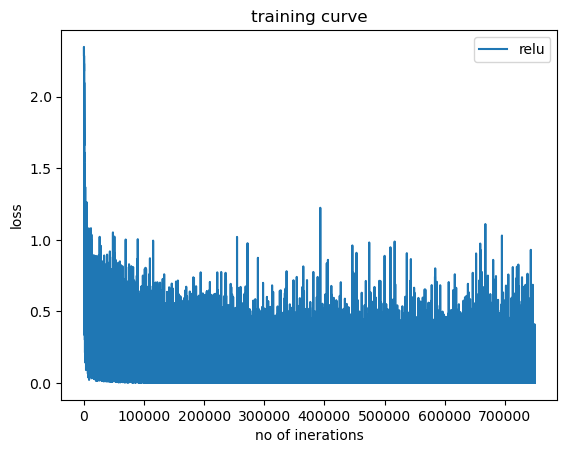

In [65]:
# Compare the training loss

plt.plot(loss_list, label='relu')
plt.ylabel('loss')
plt.xlabel('no of inerations')
plt.title('training curve')
plt.legend()
plt.show()

In [66]:
df_test = pd.read_csv('/home/bibin/MAI/2nd_sem/ANN/dataset/test.csv')

In [67]:
df_test

,id,image,classification
0,240000,240000.png,NaN
1,240001,240001.png,NaN
2,240002,240002.png,NaN
3,240003,240003.png,NaN
4,240004,240004.png,NaN
...,...,...,...
39995,279995,279995.png,NaN
39996,279996,279996.png,NaN
39997,279997,279997.png,NaN
39998,279998,279998.png,NaN


In [68]:
test_im= df_test['image'].to_list()

In [69]:
len(test_im)

40000

In [70]:
zero_test = np.zeros((40000,28,28),dtype=np.uint8) 

for i in range(40000):
    zero_test[i] = cv2.imread(f'dataset/test/{test_im[i]}',0)
    
zero_test = zero_test/255 #normalizing data

test_images = torch.tensor(zero_test).reshape((40000,1,28,28)).float() # convert from numpy array into torch tensor with shape(40000,1,28,28)

In [71]:
# Set the model to evaluation mode  or
model.eval()
classification = []
for x in test_images:
            z = model(x.reshape((1,1,28,28)))
            pred = torch.argmax(z).item()
            
            classification.append(pred)

In [72]:
classification.count(0),classification.count(1),classification.count(2),classification.count(3)

(3988, 4218, 4270, 4222)

In [73]:
import pandas as pd

classification_df = pd.DataFrame (classification, columns = ['classification'])

In [74]:
classification_df

,classification
0,6
1,9
2,0
3,8
4,2
...,...
39995,0
39996,8
39997,6
39998,8


In [75]:
df_test_submission = pd.read_csv('/home/bibin/MAI/2nd_sem/ANN/dataset/test_copy.csv')

In [76]:
df_test_submission

,id,image,classification
0,240000,240000.png,NaN
1,240001,240001.png,NaN
2,240002,240002.png,NaN
3,240003,240003.png,NaN
4,240004,240004.png,NaN
...,...,...,...
39995,279995,279995.png,NaN
39996,279996,279996.png,NaN
39997,279997,279997.png,NaN
39998,279998,279998.png,NaN


In [77]:
df_test_submission.pop('image')

0        240000.png
1        240001.png
2        240002.png
3        240003.png
4        240004.png
            ...    
39995    279995.png
39996    279996.png
39997    279997.png
39998    279998.png
39999    279999.png
Name: image, Length: 40000, dtype: object

In [78]:
df_test_submission

,id,classification
0,240000,NaN
1,240001,NaN
2,240002,NaN
3,240003,NaN
4,240004,NaN
...,...,...
39995,279995,NaN
39996,279996,NaN
39997,279997,NaN
39998,279998,NaN


In [79]:
df_test_submission["classification"] = classification_df

In [80]:
df_test_submission

,id,classification
0,240000,6
1,240001,9
2,240002,0
3,240003,8
4,240004,2
...,...,...
39995,279995,0
39996,279996,8
39997,279997,6
39998,279998,8


In [81]:
df_test_submission.to_csv('/home/bibin/MAI/2nd_sem/ANN/dataset/cnn_conv3_stride2_by_dy_100.csv', index=False)

In [82]:
df_test_submission.loc[df_test_submission['id'] == 240019]

,id,classification
19,240019,2


In [3]:
#CNN different architecture comparison
#when epochs increases upto 100 accuracy decreases maybe due to overfitting
#model without batch normalisation and dropout have less accuracy than models having those

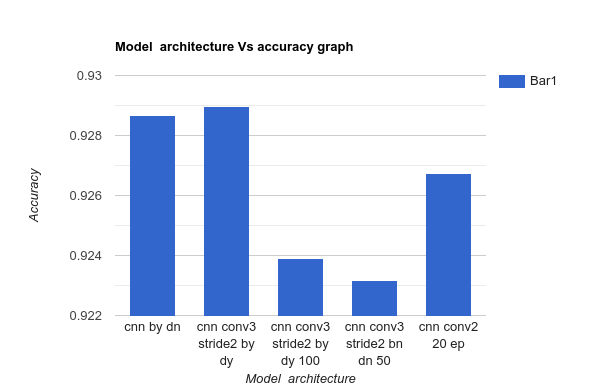